In [46]:
import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold


In [47]:
PATH_DATAPREP = "/Users/tamanna.urmi/ETA_at_checkout/model2/"

In [48]:
# import X_train, X_test, y_train, y_test

X_train_imp = pd.read_csv(PATH_DATAPREP + 'X_train_imp.csv')
X_test_imp = pd.read_csv(PATH_DATAPREP + 'X_test_imp.csv')

y_train = pd.read_csv(PATH_DATAPREP + 'y_train_imp.csv')
y_test = pd.read_csv(PATH_DATAPREP + 'y_test_imp.csv')

In [49]:
X_train = X_train_imp.drop([
'driver_id',
'merchant_id',
'customer_id',
'merchant_id_1',
'service_area_id'], axis =1)
X_test = X_test_imp.drop([
'driver_id',
'merchant_id',
'customer_id',
'merchant_id_1',
'service_area_id'], axis =1)

X_train.columns

Index(['booking_hour', 'dist_to_merch', 'booking_day', 'is_weekend',
       'normalized_gmv', 'is_sku_promo_order', 'is_voucher_order',
       'demand_service_area_1w', 'avg_gmv_service_area_1w',
       'avg_t2_service_area_1w', 'demand_service_area_1d',
       'avg_gmv_service_area_1d', 'avg_t2_service_area_1d',
       'is_merchant_in_poi', 'merchant_auto_accept_flag',
       'merch_demand_same_hour_1m', 'avg_gmv_same_hour_merchant_1m',
       'avg_t2_same_hour_merchant_1m', 'merch_demand_3h',
       'avg_gmv_merchant_3h', 'avg_t2_merchant_3h', 'merch_demand_1d',
       'avg_gmv_merchant_1d', 'avg_t2_merchant_1d', 'merch_demand_1w',
       'avg_gmv_merchant_1w', 'avg_t2_merchant_1w', 'merch_demand_3d',
       'avg_t2_merchant_3d', 'total_active_item', 'avg_merchant_price',
       'merchant_acceptance_flag', 'is_in_shopping_mall', 'total_cuisine_cnt',
       'primary_cuisine_demand_1d', 'avg_gmv_primary_cuisine_1d',
       'avg_t2_primary_cuisine_1d', 'primary_cuisine_demand_1w',
     

In [6]:
# nullXtrn = pd.DataFrame((X_train.isnull().sum()*100/len(X_train))>0, columns = ['nullhigh'])
# colstrn = nullXtrn[(nullXtrn.nullhigh==True)].index
# colstrn

Index([], dtype='object')

In [50]:
y_train1 = y_train[['actual_t2_second']]
y_train2 = y_train[['actual_t2_second_mafcorrected']]

y_test1 = y_test[['actual_t2_second']]
y_test2 = y_test[['actual_t2_second_mafcorrected']]

In [51]:
b_train = X_train[['avg_t2_merchant_1m']]
b_test = X_test[['avg_t2_merchant_1m']]

b2_train = X_train[['avg_t2_MerchantxTopic_statis']]
b2_test = X_test[['avg_t2_MerchantxTopic_statis']]

# Models

In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def mape(y_true, y_pred):
  return np.mean(abs(y_pred - y_true)*100/(y_true))

def error_grid(y_true, y_pred):
    print("Model MAE : ", mean_absolute_error(y_true, y_pred))
    print("Model MSE : ", mean_squared_error(y_true, y_pred))
    print("Model R2 : ", r2_score(y_true, y_pred))
    print("Model RMSE : ", mean_squared_error(y_true, y_pred, squared=False))
    print("Model MAPE : ", mape(y_true.values, y_pred), "\n")

In [19]:
y_test1

,actual_t2_second
0,29
1,410
2,417
3,1678
4,1860
...,...
337652,2664
337653,295
337654,910
337655,637


In [53]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train1)

y_predLR = regressor.predict(X_test)
y_predLR_df = pd.DataFrame(y_predLR, index = y_test1.index)
y_resultLR = pd.concat([y_test1, y_predLR_df], axis = 1)
y_resultLR

,actual_t2_second,0
0,887,706.256357
1,357,1073.096794
2,782,502.421942
3,422,871.000120
4,505,442.676886
...,...,...
337578,33,296.445396
337579,380,420.390567
337580,1130,660.260566
337581,1066,471.825969


In [58]:
# LR1 
print("Model comparison with t2:")
error_grid(y_test1, y_predLR)

# LR1 
print("Model comparison with t2 corrected by maf:")
error_grid(y_test2, y_predLR)

print("Baseline:")
error_grid(y_test1, b_test.values)

Model comparison with t2:
Model MAE :  246.38654881373967
Model MSE :  123454.84320358408
Model R2 :  0.4514137015766696
Model RMSE :  351.3614139366816
Model MAPE :  101.60307085417911 

Model comparison with t2 corrected by maf:
Model MAE :  288.466169665494
Model MSE :  170111.2615796224
Model R2 :  0.30593613819786647
Model RMSE :  412.4454649764286
Model MAPE :  71.95553575941862 

Baseline:
Model MAE :  257.05843328178736
Model MSE :  134276.97060271105
Model R2 :  0.40332428963547484
Model RMSE :  366.4382220821281
Model MAPE :  104.49629483023202 



In [56]:
## XGB 2
xgb2_cnf = XGBRegressor(learning_rate=0.02, max_depth = 8, objective ='reg:squarederror', \
                        colsample_bytree = 0.7, subsample = 0.8, n_estimators = 300)
## fit and predict
xgb2 = xgb2_cnf.fit(X_train, y_train1)
y_predxgb2 = xgb2.predict(X_test)  

## save results to csv
y_predxgb2_df = pd.DataFrame(y_predxgb2, index = y_test1.index, columns = y_test1.columns)
y_predxgb2_df.to_csv(PATH_DATAPREP + "y_predxgb2.csv")



In [61]:
print("Model:")
error_grid(y_test1, y_predxgb2)

print("Model comparison t2 maf corrected:")
error_grid(y_test2, y_predxgb2)
# print("Model MAPE: ", np.mean(abs(y_predxgb2_df - y_test1)/y_test1) * 100)

Model:
Model MAE :  233.2780488210675
Model MSE :  109719.92534634571
Model R2 :  0.5124464448123935
Model RMSE :  331.23998150335916
Model comparison t2 maf corrected:
Model MAE :  277.89405742994353
Model MSE :  156816.29674176613
Model R2 :  0.3601803696038338
Model RMSE :  396.0003746737699


In [71]:
print("Model MAPE: ", np.mean(abs(y_predxgb2_df.values - y_test2.values)/y_test2.values)* 100)



Model MAPE:  68.28434987461526


In [72]:
X_train.columns

Index(['booking_hour', 'dist_to_merch', 'booking_day', 'is_weekend',
       'normalized_gmv', 'is_sku_promo_order', 'is_voucher_order',
       'demand_service_area_1w', 'avg_gmv_service_area_1w',
       'avg_t2_service_area_1w', 'demand_service_area_1d',
       'avg_gmv_service_area_1d', 'avg_t2_service_area_1d',
       'is_merchant_in_poi', 'merchant_auto_accept_flag',
       'merch_demand_same_hour_1m', 'avg_gmv_same_hour_merchant_1m',
       'avg_t2_same_hour_merchant_1m', 'merch_demand_3h',
       'avg_gmv_merchant_3h', 'avg_t2_merchant_3h', 'merch_demand_1d',
       'avg_gmv_merchant_1d', 'avg_t2_merchant_1d', 'merch_demand_1w',
       'avg_gmv_merchant_1w', 'avg_t2_merchant_1w', 'merch_demand_3d',
       'avg_t2_merchant_3d', 'total_active_item', 'avg_merchant_price',
       'merchant_acceptance_flag', 'is_in_shopping_mall', 'total_cuisine_cnt',
       'primary_cuisine_demand_1d', 'avg_gmv_primary_cuisine_1d',
       'avg_t2_primary_cuisine_1d', 'primary_cuisine_demand_1w',
     

In [42]:
Pkl_Filename = "Pickle_RL_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(xgb2, file)

In [45]:
## Load pickle

with open(Pkl_Filename, 'rb') as file:  
    Pickled_xgb2_model = pickle.load(file)

Pickled_xgb2_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# fewer features

In [74]:
X_train_few = X_train[['booking_hour', #
                           'dist_to_merch', #
                           'normalized_gmv', 
                           'is_sku_promo_order',
                           'demand_service_area_1w',
                           'avg_t2_service_area_1d',
                           'avg_gmv_same_hour_merchant_1m',
                           'avg_t2_same_hour_merchant_1m', 
                           'merch_demand_3h',
                           'merch_demand_same_hour_1m',
                           'avg_t2_merchant_3h',
                           'merch_demand_1w',
                           'avg_gmv_merchant_1w', 
                           'avg_t2_merchant_1w',
                           'avg_t2_merchant_3d',
                           'avg_merchant_price',
                           'avg_gmv_primary_cuisine_1w', 
                           'avg_t2_merchant_1m',
                          'p50_t2_MerchantxTopic_statis',
                          'avg_t2_MerchantxTopic_statis'
                          ]]
X_test_few = X_test[['booking_hour', #
                           'dist_to_merch', #
                           'normalized_gmv', 
                           'is_sku_promo_order',
                           'demand_service_area_1w',
                           'avg_t2_service_area_1d',
                           'avg_gmv_same_hour_merchant_1m',
                           'avg_t2_same_hour_merchant_1m', 
                           'merch_demand_3h',
                           'merch_demand_same_hour_1m',
                           'avg_t2_merchant_3h',
                           'merch_demand_1w',
                           'avg_gmv_merchant_1w', 
                           'avg_t2_merchant_1w',
                           'avg_t2_merchant_3d',
                           'avg_merchant_price',
                           'avg_gmv_primary_cuisine_1w', 
                           'avg_t2_merchant_1m',
                          'p50_t2_MerchantxTopic_statis',
                          'avg_t2_MerchantxTopic_statis',]]

In [75]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train_few, y_train1)

y_predLR2 = regressor.predict(X_test_few)
y_predLR2_df = pd.DataFrame(y_predLR2, index = y_test1.index)
y_resultLR2 = pd.concat([y_test1, y_predLR2_df], axis = 1)
y_resultLR2

,actual_t2_second,0
0,887,653.898513
1,357,1066.878803
2,782,495.447352
3,422,847.208662
4,505,470.779444
...,...,...
337578,33,266.332464
337579,380,433.054194
337580,1130,706.861136
337581,1066,460.808801


In [80]:
# LR1 
print("Model comparison with t2:")
error_grid(y_test1, y_predLR2)
print("Model MAPE : ", mape(y_test1.values, y_predLR2))

# LR1 
print("Model comparison with t2 corrected by maf:")
error_grid(y_test2, y_predLR2)
print("Model MAPE : ", mape(y_test2.values, y_predLR2))

print("Baseline:")
error_grid(y_test1, b_test.values)
print("Model MAPE : ", mape(y_test1.values, b_test.values))
print("Baseline with t2 corrected by maf:")
error_grid(y_test2, b_test.values)
print("Model MAPE : ", mape(y_test2.values, b_test.values))


Model comparison with t2:
Model MAE :  246.90614707392285
Model MSE :  125132.1865153566
Model R2 :  0.44396022681041025
Model RMSE :  353.74028116028376
Model MAPE :  101.82991139929125
Model comparison with t2 corrected by maf:
Model MAE :  288.6522395840479
Model MSE :  171585.49880738516
Model R2 :  0.29992116438595007
Model RMSE :  414.2288000699434
Model MAPE :  71.91372289589351
Baseline:
Model MAE :  257.05843328178736
Model MSE :  134276.97060271105
Model R2 :  0.40332428963547484
Model RMSE :  366.4382220821281
Model MAPE :  104.49629483023202
Baseline with t2 corrected by maf:
Model MAE :  300.4917170353013
Model MSE :  183389.48495030904
Model R2 :  0.25176021295369033
Model RMSE :  428.23998523060527
Model MAPE :  74.23357564574422


# Feature importance

In [62]:
import eli5
from eli5.sklearn import PermutationImportance

import random
from matplotlib.pyplot import cm
import numpy as np

In [63]:
perm = PermutationImportance(xgb2_cnf, random_state=1).fit(X_test, y_test1)
a = eli5.show_weights(perm, feature_names = X_test.columns.tolist())


In [64]:
a

Weight,Feature
0.3544 ± 0.0037,avg_t2_merchant_1m
0.2589 ± 0.0026,normalized_gmv
0.0288 ± 0.0003,avg_t2_merchant_3h
0.0171 ± 0.0006,avg_t2_same_hour_merchant_1m
0.0164 ± 0.0005,avg_gmv_merchant_1w
0.0139 ± 0.0006,avg_gmv_primary_cuisine_1w
0.0092 ± 0.0002,avg_t2_merchant_1w
0.0044 ± 0.0002,merch_demand_3h
0.0040 ± 0.0003,merch_demand_same_hour_1m
0.0038 ± 0.0002,avg_gmv_same_hour_merchant_1m


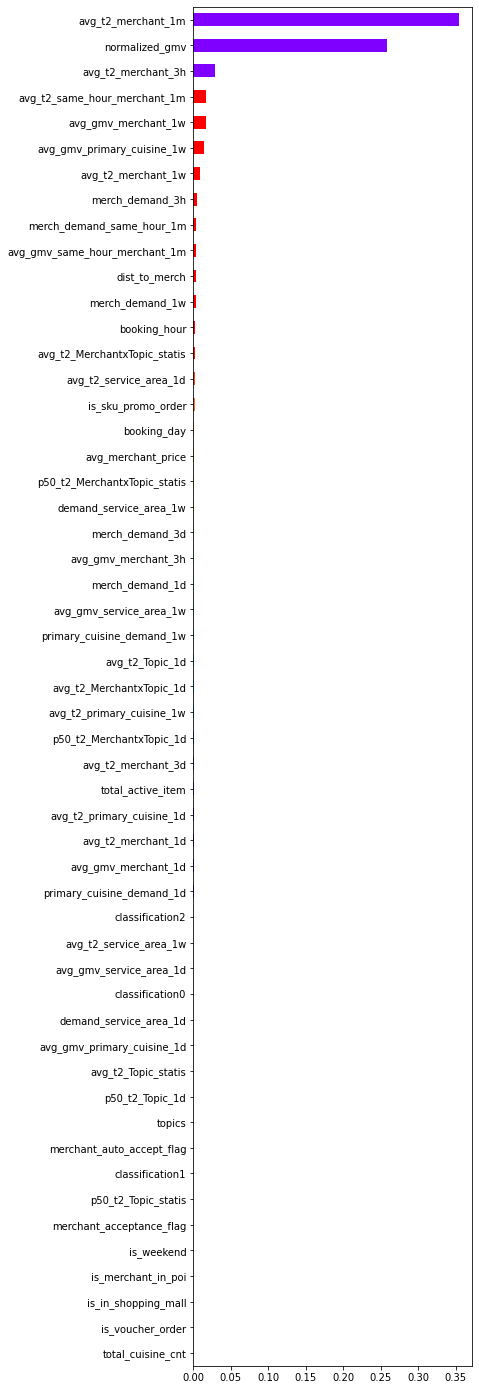

In [65]:
plt.figure(figsize=(5,25))
importances = pd.Series(perm.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color = iter(cm.rainbow(np.linspace(-1.1,1.5))));

In [ ]:
##### Ignore things below if 
##### topic features are prepared and imputed separately #####

# Model with more dominant topic features and only tested on out-of-time set

In [2]:
df = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/t2_dataset_with_traindtfeat.csv")


In [20]:
df2 = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/validation_full_dataset.csv")
df2

,order_no,customer_id,book_time,actual_t2_second,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,...,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,booking_time,dominant_topic_order_cnt,dominant_topic_average_t2_second
0,F-949956618,592556403,2020-08-25 22:47:20.954064,490.0,22,0.222,2,0,39200,0,...,0.003578,0.002237,0.004969,0.133036,0.016800,0.004937,21.0,2020-08-25 15:47:20.954064+00:00,4.0,435.500000
1,F-949748972,633224773,2020-08-25 18:45:13.439338,916.0,18,0.043,2,0,62000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F-949829025,548227529,2020-08-25 19:44:10.699199,355.0,19,0.099,2,0,12000,0,...,0.000095,0.000059,0.000132,0.000064,0.000447,0.000131,17.0,2020-08-25 12:44:10.699199+00:00,29.0,609.034483
3,F-949365659,572023544,2020-08-25 12:18:07.222764,614.0,12,0.029,2,0,33000,0,...,0.000051,0.000032,0.000070,0.000034,0.000237,0.000070,12.0,2020-08-25 05:18:07.222764+00:00,32.0,550.343750
4,F-949426174,619222777,2020-08-25 13:03:29.203951,826.0,13,1.901,2,0,16000,0,...,0.022074,0.013800,0.030648,0.014938,0.103667,0.956969,34.0,2020-08-25 06:03:29.203951+00:00,1.0,826.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894415,F-953025266,584461668,2020-08-29 13:02:20.308166,1676.0,13,0.004,6,1,177000,0,...,0.001965,0.001228,0.002728,0.108862,0.009228,0.002711,27.0,2020-08-29 06:02:20.308166+00:00,3.0,1124.666667
894416,F-953629915,555854833,2020-08-29 21:50:47.949716,1058.0,21,0.077,6,1,84000,0,...,0.000404,0.000253,0.000561,0.000274,0.001899,0.000558,2.0,2020-08-29 14:50:47.949716+00:00,3.0,1211.666667
894417,F-953492825,552059664,2020-08-29 19:30:13.487511,441.0,19,0.019,6,1,132900,1,...,0.000134,0.000084,0.000186,0.000091,0.000630,0.000185,15.0,2020-08-29 12:30:13.487511+00:00,29.0,564.551724
894418,F-953305546,578327934,2020-08-29 17:22:34.543591,807.0,17,0.024,6,1,178000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
###### Already done on dataset. DO NOT RUN THIS

# import math
# def fix_domtopic(row):
#     topic0 = row.topic0
#     dominant_topic = row.dominant_topic
#     if math.isnan(dominant_topic) == False:
#         if int(dominant_topic) > 0:
#             return dominant_topic
#         elif int(dominant_topic) == 0 and topic0 > 0:
#             return dominant_topic
#         elif int(dominant_topic) == 0 and topic0 == 0:
#             return np.nan

# # putting dominant topic
# df2['dominant_topic'] = df2[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
#    'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
#    'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18',
#    'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24',
#    'topic25', 'topic26', 'topic27', 'topic28', 'topic29', 'topic30',
#    'topic31', 'topic32', 'topic33', 'topic34']].idxmax(axis=1).str.lstrip('topic')

# df2['dominant_topic'] = pd.to_numeric(df2['dominant_topic'])

# # correct dominant topic
# df2['dominant_topic'] = df2[['topic0', 'dominant_topic']].apply(fix_domtopic, axis =1)
 

In [123]:
df2.to_csv("/Users/tamanna.urmi/ETA_at_checkout/validation_full_dataset.csv", index= False)

In [5]:
df2 = df2[df2['dominant_topic'].notna()]
df2.isnull().sum()*100/len(df2)

order_no                            0.000000
customer_id                         0.000000
book_time                           0.000000
actual_t2_second                    0.006351
booking_hour                        0.000000
                                      ...   
topic34                             0.000000
dominant_topic                      0.000000
booking_time                        0.000000
dominant_topic_order_cnt            0.000000
dominant_topic_average_t2_second    0.005022
Length: 91, dtype: float64

In [115]:
df2

,order_no,customer_id,book_time,actual_t2_second,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,...,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,booking_time,dominant_topic_order_cnt,dominant_topic_average_t2_second
0,F-949956618,592556403,2020-08-25 22:47:20.954064,490.0,22,0.222,2,0,39200,0,...,0.003578,0.002237,0.004969,0.133036,0.016800,0.004937,21.0,2020-08-25 15:47:20.954064+00:00,4.0,435.500000
2,F-949829025,548227529,2020-08-25 19:44:10.699199,355.0,19,0.099,2,0,12000,0,...,0.000095,0.000059,0.000132,0.000064,0.000447,0.000131,17.0,2020-08-25 12:44:10.699199+00:00,29.0,609.034483
3,F-949365659,572023544,2020-08-25 12:18:07.222764,614.0,12,0.029,2,0,33000,0,...,0.000051,0.000032,0.000070,0.000034,0.000237,0.000070,12.0,2020-08-25 05:18:07.222764+00:00,32.0,550.343750
4,F-949426174,619222777,2020-08-25 13:03:29.203951,826.0,13,1.901,2,0,16000,0,...,0.022074,0.013800,0.030648,0.014938,0.103667,0.956969,34.0,2020-08-25 06:03:29.203951+00:00,1.0,826.000000
8,F-949368897,645999037,2020-08-25 12:20:19.349264,288.0,12,0.666,2,0,13000,0,...,0.000164,0.000102,0.000227,0.000111,0.000769,0.000226,15.0,2020-08-25 05:20:19.349264+00:00,2.0,152.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894412,F-953304178,550787859,2020-08-29 17:21:38.769892,330.0,17,0.004,6,1,34000,0,...,0.002131,0.001332,0.002959,0.001442,0.010008,0.002940,27.0,2020-08-29 10:21:38.769892+00:00,1.0,330.000000
894414,F-953166598,558947222,2020-08-29 15:17:05.032148,411.0,15,0.008,6,1,251710,1,...,0.000122,0.000076,0.000169,0.000082,0.000571,0.000168,21.0,2020-08-29 08:17:05.032148+00:00,1.0,411.000000
894415,F-953025266,584461668,2020-08-29 13:02:20.308166,1676.0,13,0.004,6,1,177000,0,...,0.001965,0.001228,0.002728,0.108862,0.009228,0.002711,27.0,2020-08-29 06:02:20.308166+00:00,3.0,1124.666667
894416,F-953629915,555854833,2020-08-29 21:50:47.949716,1058.0,21,0.077,6,1,84000,0,...,0.000404,0.000253,0.000561,0.000274,0.001899,0.000558,2.0,2020-08-29 14:50:47.949716+00:00,3.0,1211.666667


In [21]:
dominant_topic_merchant_features_with_train = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/dominant_topic_merchant_features_with_train.csv")
dominant_topic_features_with_train = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/dominant_topic_features_with_train.csv")


In [120]:
dominant_topic_merchant_features_with_train.merchant_id.nunique()

286487

In [22]:
# Change dominant topic features
df2 = df2.drop(['booking_time', 'dominant_topic_order_cnt', 'dominant_topic_average_t2_second'], axis = 1)
df3 = pd.merge(df2, dominant_topic_merchant_features_with_train, how = 'left', on = ['dominant_topic', 'merchant_id'])


map_dtcnt = df3['dominant_topic'].map(dominant_topic_features_with_train.set_index('dominant_topic')['dominant_topic_order_cnt'])
df3['dominant_topic_merchant_order_cnt'] = df3['dominant_topic_merchant_order_cnt'].fillna(map_dtcnt/dominant_topic_merchant_features_with_train.merchant_id.nunique())

map_dtt2 = df3['dominant_topic'].map(dominant_topic_features_with_train.set_index('dominant_topic')['dominant_topic_average_t2_second'])
df3['dominant_topic_merchant_average_t2_second'] = df3['dominant_topic_merchant_average_t2_second'].fillna(map_dtt2)

df3


,order_no,customer_id,book_time,actual_t2_second,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,...,topic28,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,dominant_topic_merchant_order_cnt,dominant_topic_merchant_average_t2_second
0,F-949956618,592556403,2020-08-25 22:47:20.954064,490.0,22,0.222,2,0,39200,0,...,0.003189,0.003578,0.002237,0.004969,0.133036,0.016800,0.004937,21.0,15.0,338.800000
1,F-949748972,633224773,2020-08-25 18:45:13.439338,916.0,18,0.043,2,0,62000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F-949829025,548227529,2020-08-25 19:44:10.699199,355.0,19,0.099,2,0,12000,0,...,0.000085,0.000095,0.000059,0.000132,0.000064,0.000447,0.000131,17.0,94.0,575.808511
3,F-949365659,572023544,2020-08-25 12:18:07.222764,614.0,12,0.029,2,0,33000,0,...,0.000045,0.000051,0.000032,0.000070,0.000034,0.000237,0.000070,12.0,112.0,615.303571
4,F-949426174,619222777,2020-08-25 13:03:29.203951,826.0,13,1.901,2,0,16000,0,...,0.019681,0.022074,0.013800,0.030648,0.014938,0.103667,0.956969,34.0,1.0,698.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894415,F-953025266,584461668,2020-08-29 13:02:20.308166,1676.0,13,0.004,6,1,177000,0,...,0.001752,0.001965,0.001228,0.002728,0.108862,0.009228,0.002711,27.0,2.0,726.500000
894416,F-953629915,555854833,2020-08-29 21:50:47.949716,1058.0,21,0.077,6,1,84000,0,...,0.000360,0.000404,0.000253,0.000561,0.000274,0.001899,0.000558,2.0,33.0,839.848485
894417,F-953492825,552059664,2020-08-29 19:30:13.487511,441.0,19,0.019,6,1,132900,1,...,0.000120,0.000134,0.000084,0.000186,0.000091,0.000630,0.000185,15.0,67.0,527.358209
894418,F-953305546,578327934,2020-08-29 17:22:34.543591,807.0,17,0.024,6,1,178000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
df3.to_csv("/Users/tamanna.urmi/ETA_at_checkout/val_dataset_with_traindtfeat.csv", index = False)

In [23]:
X_train = df
X_test = df3


In [ ]:
import seaborn as sns
sns.pairplot(X_train.iloc[:, 0:20])

In [ ]:
sns.pairplot(X_train.iloc[:, 20:40])

In [24]:
# create final X_train, X_test, y_train, y_test
y_train = X_train[['actual_t2_second']]
y_test = X_test[['actual_t2_second']]

X_train = X_train.drop(['order_no', 'merchant_id', 'actual_t2_second'], axis = 1)
X_test = X_test.drop(['order_no', 'merchant_id', 'customer_id', 'book_time','classification', 'actual_t2_second','std_t2_same_hour_merchant_1m'], axis = 1)


In [136]:
np.mean(X_train.dominant_topic_merchant_order_cnt)

37.91393779950485

In [25]:
nullXtrn = pd.DataFrame((X_train.isnull().sum()*100/len(X_train))>0, columns = ['nullhigh'])
colstrn = nullXtrn[(nullXtrn.nullhigh==True)].index

for col in colstrn:
#     print('start', col)
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
nullXtst = pd.DataFrame((X_test.isnull().sum()*100/len(X_test))>0, columns = ['nullhigh'])
colstst = nullXtst[(nullXtst.nullhigh==True)].index

for col in colstst:
    X_test[col] = X_test[col].fillna(X_train[col].mean())


b_train = X_train[['avg_t2_merchant_1m']]
b_test = X_test[['avg_t2_merchant_1m']]

b2_train = X_train[['dominant_topic_merchant_average_t2_second']]
b2_test = X_test[['dominant_topic_merchant_average_t2_second']]

In [26]:
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_train.mean())

In [138]:
X_train

,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,is_voucher_order,demand_service_area_1w,avg_gmv_service_area_1w,avg_t2_service_area_1w,...,topic28,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,dominant_topic_merchant_order_cnt,dominant_topic_merchant_average_t2_second
0,18,0.045,5,0,175000.0,1,0,124461,52132.894385,562.889536,...,0.022838,0.019295,0.051717,0.021883,0.044883,0.008746,0.022343,16.36919,37.913938,584.725259
1,19,0.055,5,0,66000.0,1,1,99864,54560.093938,586.462410,...,0.000091,0.000102,0.000064,0.000142,0.000069,0.000480,0.000141,2.00000,53.000000,600.509434
2,15,0.243,5,0,13750.0,0,0,400348,50368.082928,601.531297,...,0.003244,0.003639,0.002275,0.005052,0.002462,0.017089,0.005021,25.00000,52.000000,686.480769
3,11,0.103,5,0,42000.0,0,0,445922,55637.321632,569.582618,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.36919,37.913938,584.725259
4,14,0.448,5,0,27000.0,0,0,4432,50901.473827,508.140794,...,0.000089,0.000099,0.579161,0.138071,0.000067,0.000466,0.000137,3.00000,1.000000,179.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594422,18,0.130,6,1,98502.0,0,0,2343323,69855.629732,604.551774,...,0.001572,0.000030,0.035711,0.021093,0.041972,0.000139,0.000041,23.00000,108.000000,1243.685185
1594423,11,0.264,6,1,128000.0,0,0,2343323,69855.629732,604.551774,...,0.022838,0.019295,0.051717,0.021883,0.044883,0.008746,0.022343,16.36919,37.913938,584.725259
1594424,20,0.341,6,1,27500.0,1,1,2343323,69855.629732,604.551774,...,0.000038,0.000042,0.117970,0.055561,0.053701,0.000199,0.000059,14.00000,4.000000,574.750000
1594425,18,0.291,6,1,49000.0,0,0,2343323,69855.629732,604.551774,...,0.000903,0.001013,0.000633,0.001407,0.000686,0.004759,0.001398,10.00000,58.000000,302.379310


In [139]:
X_test

,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,is_voucher_order,demand_service_area_1w,avg_gmv_service_area_1w,avg_t2_service_area_1w,...,topic28,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,dominant_topic_merchant_order_cnt,dominant_topic_merchant_average_t2_second
0,22,0.222,2,0,39200,0,1,52755,55714.388437,578.920121,...,0.003189,0.003578,0.002237,0.004969,0.133036,0.016800,0.004937,21.0,15.000000,338.800000
1,19,0.099,2,0,12000,0,0,15072,45793.248872,607.936998,...,0.000085,0.000095,0.000059,0.000132,0.000064,0.000447,0.000131,17.0,94.000000,575.808511
2,12,0.029,2,0,33000,0,0,353091,52304.513865,623.274049,...,0.000045,0.000051,0.000032,0.000070,0.000034,0.000237,0.000070,12.0,112.000000,615.303571
3,13,1.901,2,0,16000,0,0,9653,49142.042888,635.415812,...,0.019681,0.022074,0.013800,0.030648,0.014938,0.103667,0.956969,34.0,1.000000,698.000000
4,12,0.666,2,0,13000,0,0,23101,49943.796719,640.119957,...,0.000146,0.000164,0.000102,0.000227,0.000111,0.000769,0.000226,15.0,1.000000,306.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677066,17,0.004,6,1,34000,0,0,2275079,69992.734156,600.117765,...,0.001900,0.002131,0.001332,0.002959,0.001442,0.010008,0.002940,27.0,0.538045,604.183875
677067,15,0.008,6,1,251710,1,0,2275079,69992.734156,600.117765,...,0.000108,0.000122,0.000076,0.000169,0.000082,0.000571,0.000168,21.0,0.835563,454.986582
677068,13,0.004,6,1,177000,0,0,2275079,69992.734156,600.117765,...,0.001752,0.001965,0.001228,0.002728,0.108862,0.009228,0.002711,27.0,2.000000,726.500000
677069,21,0.077,6,1,84000,0,0,2275079,69992.734156,600.117765,...,0.000360,0.000404,0.000253,0.000561,0.000274,0.001899,0.000558,2.0,33.000000,839.848485


# Models

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def mape(y_true, y_pred):
  return np.mean(abs(y_pred - y_true)*100/(y_true))

def error_grid(y_true, y_pred):
    print("Model MAE : ", mean_absolute_error(y_true, y_pred))
    print("Model MSE : ", mean_squared_error(y_true, y_pred))
    print("Model R2 : ", r2_score(y_true, y_pred))
    print("Model RMSE : ", mean_squared_error(y_true, y_pred, squared=False))

In [151]:
X_train.columns

Index(['booking_hour', 'dist_to_merch', 'booking_day', 'is_weekend',
       'normalized_gmv', 'is_sku_promo_order', 'is_voucher_order',
       'demand_service_area_1w', 'avg_gmv_service_area_1w',
       'avg_t2_service_area_1w', 'demand_service_area_1d',
       'avg_gmv_service_area_1d', 'avg_t2_service_area_1d',
       'avg_t2_merchant_1m', 'is_merchant_in_poi', 'merchant_acceptance_flag',
       'merchant_auto_accept_flag', 'merchant_goresto_flag',
       'merch_demand_same_hour_1m', 'avg_gmv_same_hour_merchant_1m',
       'avg_t2_same_hour_merchant_1m', 'merch_demand_3h',
       'avg_gmv_merchant_3h', 'avg_t2_merchant_3h', 'merch_demand_1d',
       'avg_gmv_merchant_1d', 'avg_t2_merchant_1d', 'merch_demand_1w',
       'avg_gmv_merchant_1w', 'avg_t2_merchant_1w', 'merch_demand_3d',
       'avg_t2_merchant_3d', 'total_active_item', 'avg_merchant_price',
       'is_in_shopping_mall', 'total_cuisine_cnt', 'primary_cuisine_demand_1d',
       'avg_gmv_primary_cuisine_1d', 'avg_t2_primary_

In [35]:
X_train2 = X_train[['normalized_gmv', 'avg_t2_merchant_3h', 'avg_t2_merchant_1m', 'avg_gmv_same_hour_merchant_1m', 'avg_gmv_primary_cuisine_1w',
       'avg_t2_primary_cuisine_1w', 'avg_t2_same_hour_merchant_1m', 'avg_gmv_service_area_1w', \
        'dominant_topic_merchant_average_t2_second', 'is_sku_promo_order', 'is_voucher_order', 'booking_hour']]
X_test2 = X_test[['normalized_gmv', 'avg_t2_merchant_3h', 'avg_t2_merchant_1m', 'avg_gmv_same_hour_merchant_1m', 'avg_gmv_primary_cuisine_1w',
       'avg_t2_primary_cuisine_1w', 'avg_t2_same_hour_merchant_1m', 'avg_gmv_service_area_1w',\
                  'dominant_topic_merchant_average_t2_second', 'is_sku_promo_order', 'is_voucher_order', 'booking_hour']]


In [36]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train2, y_train)

y_predLR = regressor.predict(X_test2)
y_predLR_df = pd.DataFrame(y_predLR, index = y_test.index)
y_resultLR = pd.concat([y_test, y_predLR_df], axis = 1)
y_resultLR

,actual_t2_second,0
0,490.0,331.993397
1,916.0,673.202952
2,355.0,597.453834
3,614.0,637.150213
4,826.0,648.990859
...,...,...
894415,1676.0,822.979893
894416,1058.0,777.560096
894417,441.0,667.548806
894418,807.0,992.395911


In [39]:
# LR1 
print("Model:")
error_grid(y_test, y_predLR)
print("Baseline:")
error_grid(y_test, b_test.values)

Model:
Model MAE :  313.8113844074402
Model MSE :  193478.75663512672
Model R2 :  0.2341689744314922
Model RMSE :  439.86220187136644
Model MAPE :  118.7045153858338 

Baseline:
Model MAE :  337.81334025803335
Model MSE :  221462.41553058402
Model R2 :  0.12340356243598971
Model RMSE :  470.5979340483594
Model MAPE :  130.08428539130182 



In [164]:
# LR2 
print("Model:")
error_grid(y_test, y_predLR)
print("Baseline:")
error_grid(y_test, b_test.values)

Model:
Model MAE :  313.87628936457253
Model MSE :  195649.06356139778
Model R2 :  0.23547029096541172
Model RMSE :  442.32235254551375
Model MAPE :  111.94097337476083 

Baseline:
Model MAE :  340.18133756914665
Model MSE :  225750.86584799582
Model R2 :  0.11784273004244583
Model RMSE :  475.13247189388755
Model MAPE :  126.28591550457014 



In [162]:
X_train2.isnull().sum()

normalized_gmv                               0
avg_t2_merchant_3h                           0
avg_t2_merchant_1m                           0
avg_gmv_same_hour_merchant_1m                0
avg_gmv_primary_cuisine_1w                   0
avg_t2_primary_cuisine_1w                    0
avg_t2_same_hour_merchant_1m                 0
avg_gmv_service_area_1w                      0
dominant_topic_merchant_order_cnt            0
avg_gmv_same_hour_merchant_1m                0
dominant_topic_merchant_average_t2_second    0
is_sku_promo_order                           0
is_voucher_order                             0
booking_hour                                 0
dtype: int64

In [40]:
## XGB 2
xgb2_cnf = XGBRegressor(learning_rate=0.02, max_depth = 8, objective ='reg:squarederror', \
                        colsample_bytree = 0.7, subsample = 0.8, n_estimators = 300)

xgb2 = xgb2_cnf.fit(X_train2, y_train)
y_predxgb2 = xgb2.predict(X_test2)
y_predxgb2_df = pd.DataFrame(y_predxgb2, index = y_test.index, columns = y_test.columns)

# y_predxgb2_df.to_csv("/Users/tamanna.urmi/ETA_at_checkout/y_predxgb2.csv", index = False)

# print("Model:")
# error_grid(y_test, y_predxgb2)
# print("Model MAPE: ", np.mean(abs(y_predxgb2_df - y_test)/y_test) * 100)

In [1]:
import pandas as pd
y_predxgb2_df = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/y_predxgb2.csv")

In [12]:
y_test

,actual_t2_second
0,490.0
1,355.0
2,614.0
3,826.0
4,288.0
...,...
677066,330.0
677067,411.0
677068,1676.0
677069,1058.0


In [ ]:
print("Model:")
error_grid(y_test, y_predxgb2)

Model:
Model MAE :  299.2031519841884
Model MSE :  179495.2857050256
Model R2 :  0.28951859559740833
Model RMSE :  423.66883966728733


In [ ]:
t = y_predxgb2_df[['actual_t2_second']]

In [18]:
import numpy as np
np.mean(abs(t - y_test)/y_test) * 100

actual_t2_second    109.285606
dtype: float64

In [19]:
X_test2

NameError: name 'X_test2' is not defined

In [32]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb2_cnf, random_state=1).fit(X_test2, y_test)
a = eli5.show_weights(perm, feature_names = X_test2.columns.tolist())
a

/Users/tamanna.urmi/virtualenv/gojek_feast/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/tamanna.urmi/virtualenv/gojek_feast/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.2745 ± 0.0014,avg_t2_merchant_1m
0.1730 ± 0.0010,normalized_gmv
0.0895 ± 0.0004,dominant_topic_merchant_average_t2_second
0.0245 ± 0.0004,avg_gmv_primary_cuisine_1w
0.0143 ± 0.0002,avg_t2_merchant_3h
0.0127 ± 0.0001,avg_t2_same_hour_merchant_1m
0.0081 ± 0.0003,avg_gmv_same_hour_merchant_1m
0.0021 ± 0.0001,booking_hour
0.0016 ± 0.0000,is_sku_promo_order
0.0011 ± 0.0001,avg_t2_primary_cuisine_1w


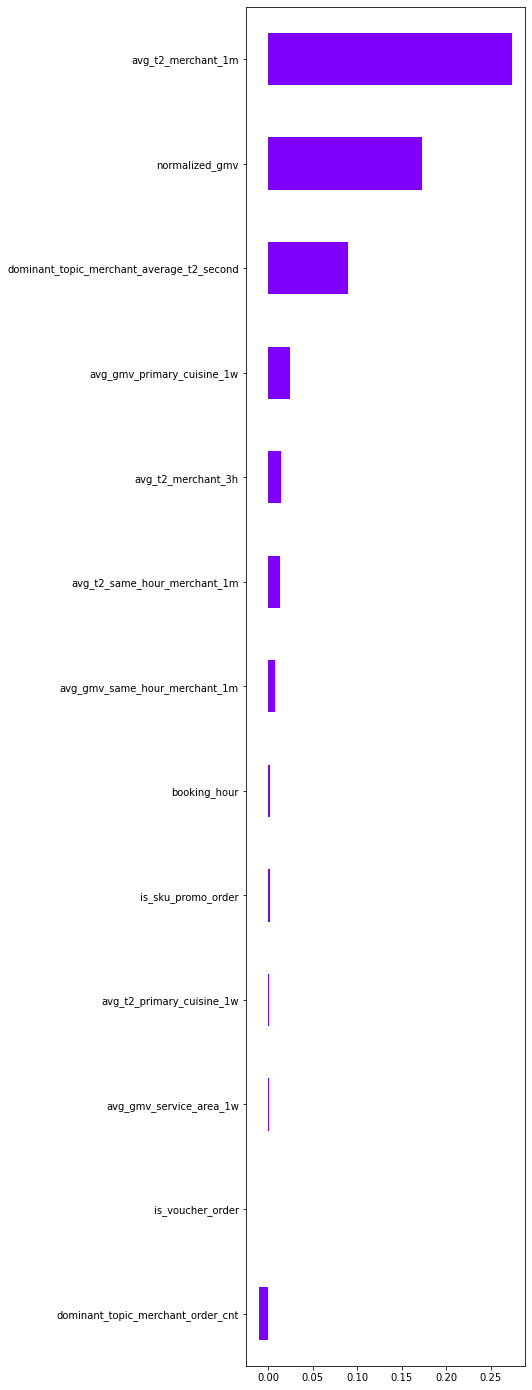

In [33]:
import random
from matplotlib.pyplot import cm
import numpy as np

plt.figure(figsize=(5,25))
importances = pd.Series(perm.feature_importances_, X_train2.columns)
importances.sort_values().plot.barh(color = iter(cm.rainbow(np.linspace(-1.1,1.5))));